## Notes:
Filtering with timeframe LDA doesn't affect anything

TODO:
- pre-whtening
- Canonical Correlation Analysis
- Bayesian LDA
- Common Average Reference
- TVLDA
- Look for outliars
- Neural network

In [83]:
!pip install mne

You should consider upgrading via the '/home/malyshev/.pyenv/versions/3.9.2/envs/imagedl/bin/python3.9 -m pip install --upgrade pip' command.


In [84]:
import os
import numpy as np
import mne
from mne.externals.pymatreader import read_mat
import scipy.signal as sig
import matplotlib.pyplot as plt

In [85]:
raw = read_mat(
    "/home/malyshev/Projects/hackthat-p300/data/S1.mat"
)
fs = 250
raw["info"] = mne.create_info(["1","2","3","4","5","6","7","8"], 250)

In [86]:
trig = raw['trig']
data = raw['y']

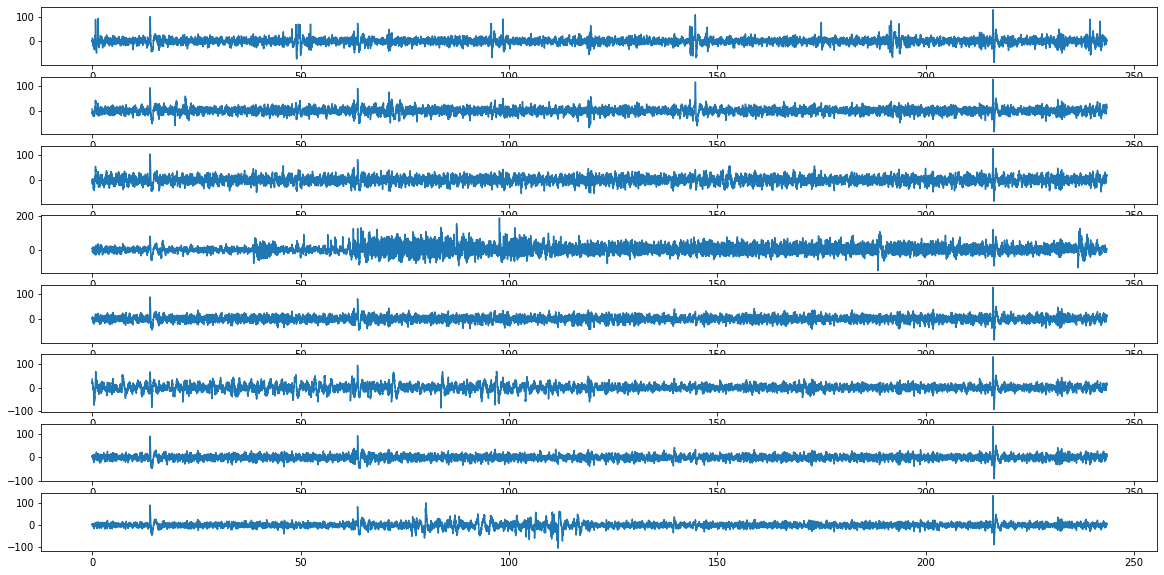

In [87]:
def plot_signal(signals: np.ndarray, sep=False):
    plt.figure(figsize=[20,10])
    N = signals.shape[0]
    for i in range(signals.shape[1]):
        if sep:
            plt.subplot(8,1,i+1)
        plt.plot(np.linspace(0,N/fs,N),signals[:,i])
    plt.show()

plot_signal(data, True)

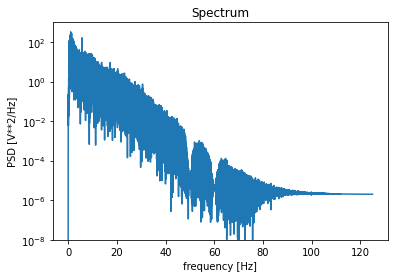

In [88]:
f, Pxx_den = sig.periodogram(data[:,0], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Spectrum')
plt.show()

## Filter and preview

In [106]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sig.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

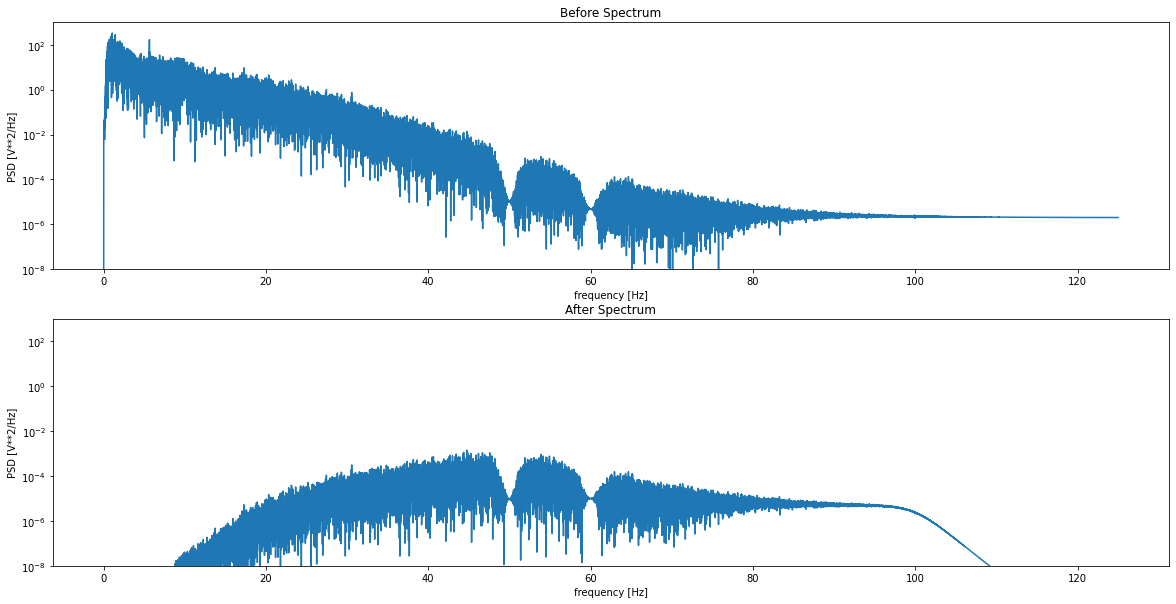

In [107]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.semilogy(*sig.periodogram(data[:,0], fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Before Spectrum')


plt.subplot(2,1,2)
plt.semilogy(*sig.periodogram(butter_bandpass_filter(data[:,0],50,100,fs), fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('After Spectrum')
plt.show()

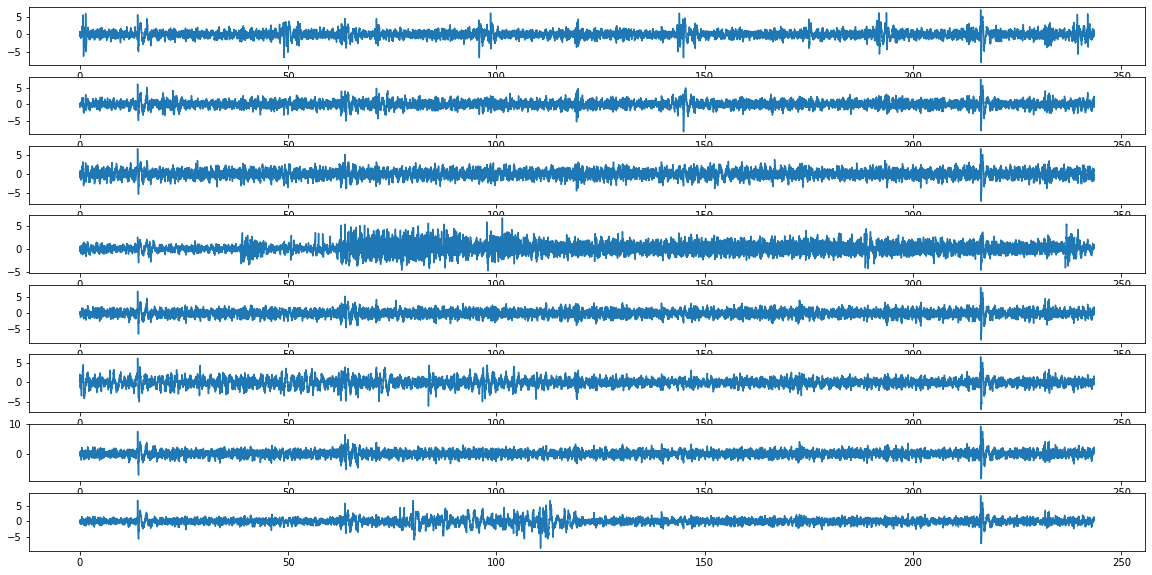

In [108]:
filtered = data.copy()
for i in range(filtered.shape[1]):
    filtered[:,i] = butter_bandpass_filter(data[:,i], 0.5, 30, fs)
filtered = (filtered - filtered.mean(0)[None]) / filtered.std(0)[None]
plot_signal(filtered, True)

## Show near label

75


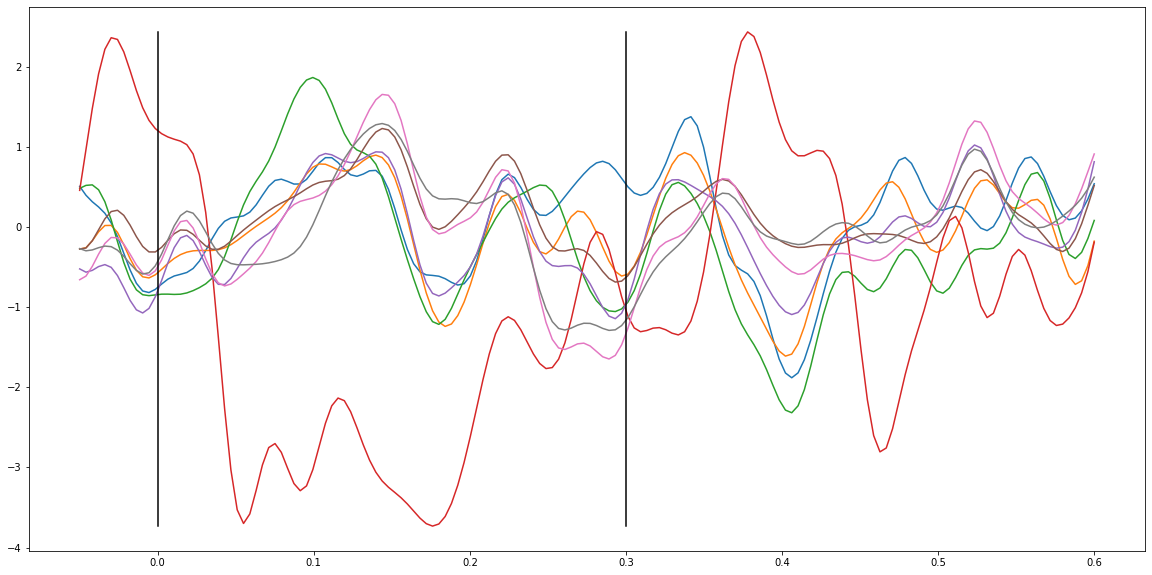

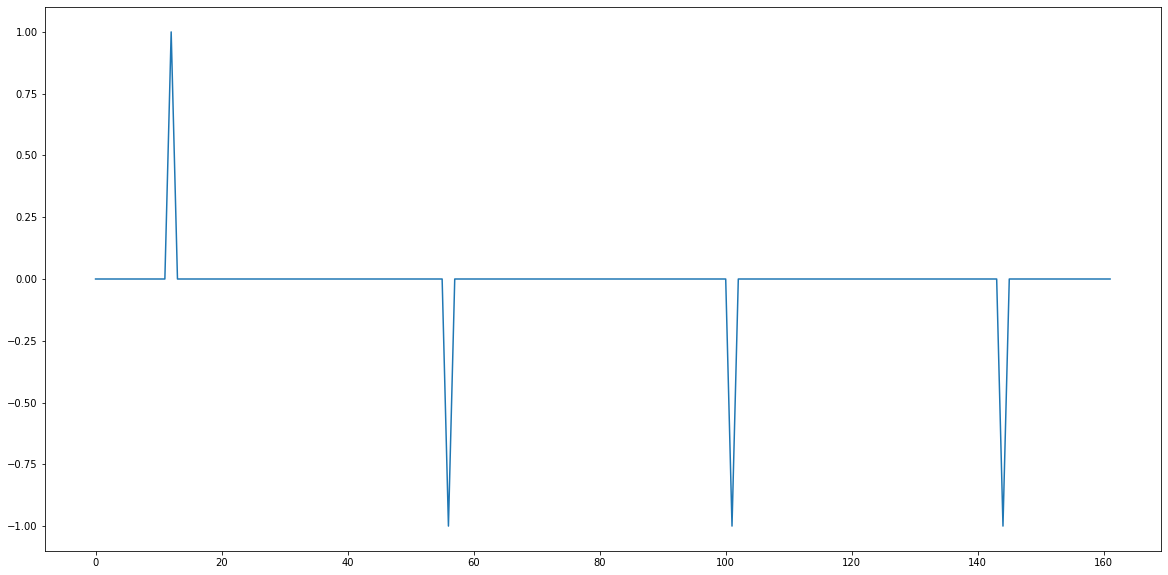

In [109]:
last = np.where(trig == 1)[0][-1]
p300 = int(0.3 * fs)
before = int(0.05 * fs)
print(p300)
plt.figure(figsize=(20,10))
sec = filtered[last-before:last + p300*2]
plt.plot(np.linspace(-0.05,0.3*2,sec.shape[0]),sec)
plt.plot([0.0]*2, [sec.min(), sec.max()], c='black')
plt.plot([0.3]*2, [sec.min(), sec.max()], c='black')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(trig[last-before:last + p300*2])
plt.show()

### Classification

In [110]:
from sklearn.discriminant_analysis import *
from sklearn.decomposition import PCA

In [111]:
y = []
xs = []
for i in np.where(trig != 0)[0]:
    xs.append(filtered[i-before:i+p300*2])
    y.append((trig[i]+1) / 2)
y = np.array(y)
X = np.stack(xs)

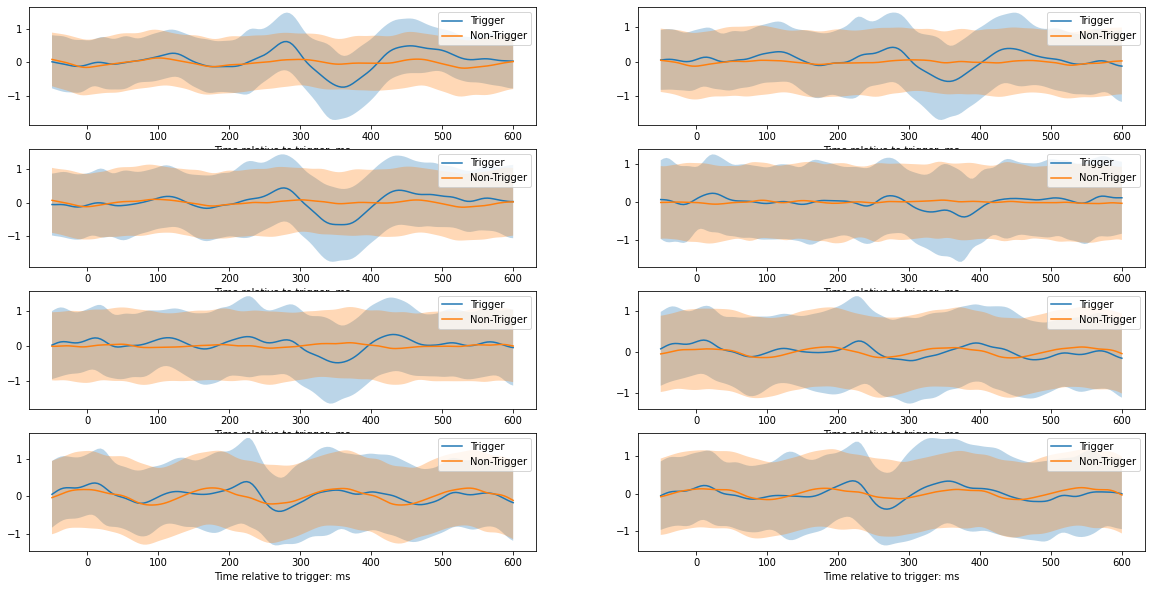

In [112]:
plt.figure(figsize=(20,10))
t = np.linspace(-50,600,X.shape[1])
for i in range(8):
    plt.subplot(4,2,i+1)
    mean = X[y==1,:,i].mean(0)
    std = X[y==1,:,i].std(0)
    plt.plot(t,mean, label='Trigger')
    plt.fill_between(t,mean-std, mean+std, alpha=0.3)
    mean = X[y==0,:,i].mean(0)
    std = X[y==0,:,i].std(0)
    plt.plot(t,mean, label='Non-Trigger')
    plt.fill_between(t,mean-std, mean+std, alpha=0.3)
    plt.legend()
    plt.xlabel('Time relative to trigger: ms')
plt.show()

[0.11511789 0.09282197 0.05575301 0.04975647 0.04450789 0.04356855
 0.02756407 0.02595706]


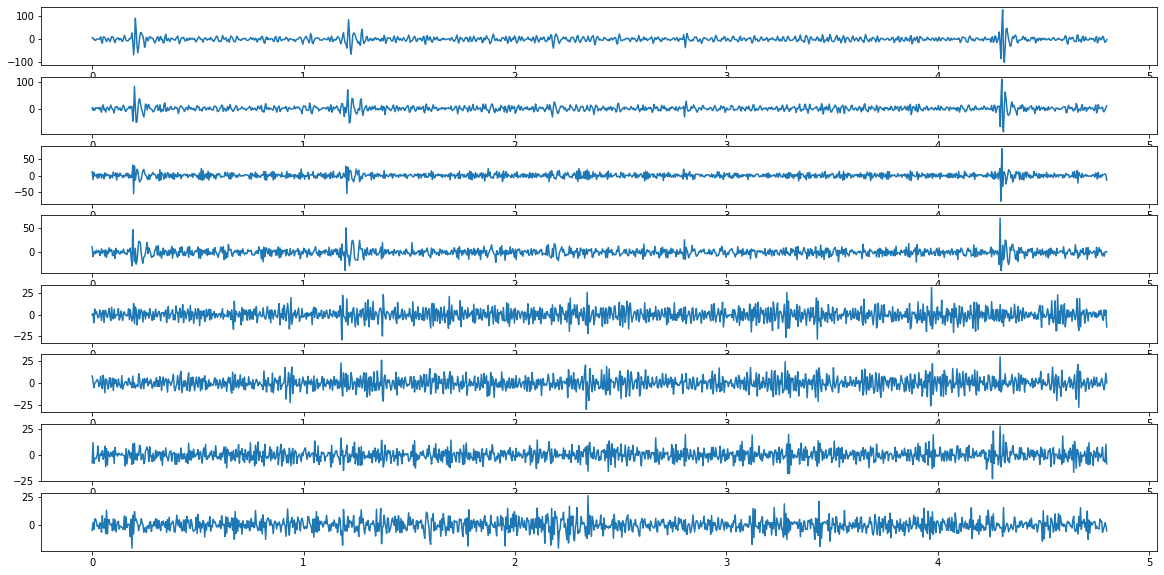

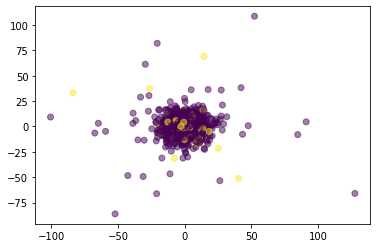

In [113]:
pca = PCA(n_components=8)
X_flat = X.reshape((X.shape[0],-1))
transformed = pca.fit_transform(X_flat)
print(pca.explained_variance_ratio_)
plot_signal(transformed, True)
plt.scatter(transformed[:,0], transformed[:,1],alpha=0.5, c=y)

0.9983333333333333


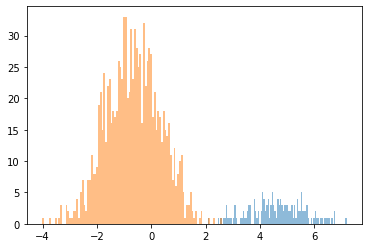

In [114]:
lda = LinearDiscriminantAnalysis()
res = lda.fit_transform(X_flat, y)
print(lda.score(X_flat, y))
plt.hist(res[y==1],bins=100,alpha=0.5)
plt.hist(res[y==0],bins=100,alpha=0.5)
plt.show()

In [115]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_flat, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('Data split: %.3f' % max(1 - y.mean(),y.mean()))

Mean Accuracy: 0.882 (0.027)
Data split: 0.875


### Neural network

In [263]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [264]:
Xten = torch.tensor(X, dtype=torch.float32).transpose(1,2)
yten = torch.tensor(y)[...,None]

In [265]:
import sys
sys.path.append('/home/malyshev/Projects/Image_Analysis_DL')
from imagedl.nn.models.blocks import Mish
from imagedl.nn.optim import AdamP

In [270]:
def create_block(in_f, out_f, ker_size = 3):
    return nn.Sequential(
        nn.Conv1d(in_f,out_f,ker_size),
        Mish(),
        nn.BatchNorm1d(out_f)
    ) 

def create_net():
    return nn.Sequential(
        create_block(8,16),
        create_block(16,32,5),
        nn.MaxPool1d(2),
        create_block(32,32,5),
        nn.MaxPool1d(2),
        create_block(32,32,3),
        nn.MaxPool1d(2),
        create_block(32,16,3),
        create_block(16,8,3),
        nn.MaxPool1d(2),
        create_block(8,8,3),
        nn.MaxPool1d(4),
        create_block(8,1,1),
        nn.Flatten(),
    )



In [271]:
N = len(Xten)
K = N // 5

TEST = []
for fold in range(5):
    print(f"FOLD {fold}")
    net = create_net()
    optim = AdamP(net.parameters())
    crit = nn.BCEWithLogitsLoss()
    res = 0
    train_Xten = TensorDataset(torch.cat([Xten[:fold*K], Xten[fold*K+K:]]))
    val_Xten = TensorDataset(Xten[fold*K:fold*K+K])
    
    train_yten = TensorDataset(torch.cat([yten[:fold*K], yten[fold*K+K:]]))
    val_yten = TensorDataset(yten[fold*K:fold*K+K])

    txdl = DataLoader(train_Xten, batch_size=4)
    tydl = DataLoader(train_yten, batch_size=4)
    vxdl = DataLoader(val_Xten, batch_size=4)
    vydl = DataLoader(val_yten, batch_size=4)
    
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        net.train()
        for i, data in enumerate(zip(txdl, tydl), 0):
            inputs, labels = data
            inputs, labels = inputs[0], labels[0]
            optim.zero_grad()

            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            optim.step()

            # print statistics
            running_loss += loss.item()
        
        with torch.no_grad():
            net.eval()
            acc = 0
            loss = 0
            for inp, lab in zip(vxdl, vydl):
                inp, lab = inp[0], lab[0]
            
                output = net(inp)
                acc += ((output > 0) == lab).sum()
                loss += crit(output, lab)
        print(f'[{epoch+1}] Training loss: {(running_loss / len(train_Xten)):.3f}')
        print(f'Validation Acc: {((acc / K).item()):.4f}  Loss: {(loss / K):.4f}')
        res = max(res, acc / K)
    TEST.append(res)
    print('====================================')
print('Finished Training')

FOLD 0
[1] Training loss: 0.178
Validation Acc: 0.7250  Loss: 0.1608
[2] Training loss: 0.147
Validation Acc: 0.7250  Loss: 0.1647
[3] Training loss: 0.128
Validation Acc: 0.8250  Loss: 0.1212
[4] Training loss: 0.109
Validation Acc: 0.8958  Loss: 0.1003
[5] Training loss: 0.098
Validation Acc: 0.8875  Loss: 0.0890
[6] Training loss: 0.093
Validation Acc: 0.9333  Loss: 0.0782
[7] Training loss: 0.084
Validation Acc: 0.9083  Loss: 0.0782
[8] Training loss: 0.078
Validation Acc: 0.9000  Loss: 0.0733
[9] Training loss: 0.078
Validation Acc: 0.8500  Loss: 0.0940
[10] Training loss: 0.081
Validation Acc: 0.8167  Loss: 0.1108
FOLD 1
[1] Training loss: 0.183
Validation Acc: 0.6750  Loss: 0.1847
[2] Training loss: 0.145
Validation Acc: 0.7542  Loss: 0.1444
[3] Training loss: 0.125
Validation Acc: 0.8292  Loss: 0.1270
[4] Training loss: 0.112
Validation Acc: 0.8917  Loss: 0.0992
[5] Training loss: 0.100
Validation Acc: 0.8875  Loss: 0.1025
[6] Training loss: 0.092
Validation Acc: 0.8917  Loss: 

In [273]:
np.mean(TEST)

0.9125